# Train RoBERTa model on NER:

In [1]:
!pip install seqeval evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.1 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=7350c1144ceda996ca3cd9103ed47f5caf1f167ffa5bf07054acabc146662aec
  Stored in directory: /root/.cache/pip/wheels/5f/b8/73/0b2c1a76b701a677653dd79ece07cfabd7457989dbfbdcd8d7
Successfully built seqeval


In [2]:
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, AutoModelForTokenClassification,
    TrainingArguments, Trainer, DataCollatorForTokenClassification
)
import numpy as np
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
import evaluate
import json
from tqdm import tqdm
import random
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Read Conll2003 Dataset

In [3]:
def read_conll_file(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        content = f.read().strip()
        sentences = content.split("\n\n")
        data = []
        for sentence in sentences:
            if not sentence.strip():
                continue
            tokens = [line.split() for line in sentence.split("\n") if line.strip()]
            data.append(tokens)
        return data

base_path = "/content/drive/MyDrive/conll2003/"
train_data = read_conll_file(base_path + "eng.train")
valid_data = read_conll_file(base_path + "eng.testa")
test_data  = read_conll_file(base_path + "eng.testb")

### Build tag mapping

In [4]:
label_list = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for label, i in label2id.items()}

def extract_tokens_and_labels(data):
    tokens_list = []
    labels_list = []
    for sentence in data:
        tokens = [t[0] for t in sentence]
        labels = [t[3] for t in sentence]
        tokens_list.append(tokens)
        labels_list.append([label2id[l] for l in labels])
    return {"tokens": tokens_list, "ner_tags": labels_list}

raw_datasets = DatasetDict({
    "train": Dataset.from_dict(extract_tokens_and_labels(train_data)),
    "validation": Dataset.from_dict(extract_tokens_and_labels(valid_data)),
    "test": Dataset.from_dict(extract_tokens_and_labels(test_data)),
})


### Import Base Model and Tokenizer

In [5]:
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)
model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Label alignment function

In [6]:
data_collator = DataCollatorForTokenClassification(tokenizer)

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        max_length=512,
        return_overflowing_tokens=False,
    )

    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        label_ids = []
        prev_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != prev_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(label[word_idx] if label[word_idx] % 2 == 1 else -100)
            prev_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets["train"].column_names
)

Map:   0%|          | 0/14987 [00:00<?, ? examples/s]

Map:   0%|          | 0/3466 [00:00<?, ? examples/s]

Map:   0%|          | 0/3684 [00:00<?, ? examples/s]

### Evaluation indicators(Use seqeval)

In [7]:
seqeval = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

### Train config

In [8]:
training_args = TrainingArguments(
    output_dir=base_path + "results",
    eval_strategy="steps",
    eval_steps=200,
    save_strategy="steps",
    save_steps=1400,

    logging_strategy="steps",
    logging_steps=100,

    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    push_to_hub=False,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-1513305485.py:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


### Train and eval

In [9]:
trainer.train()

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
200,0.148200,0.132809,0.869577,0.882225,0.875856,0.972040
400,0.081400,0.076259,0.923200,0.928693,0.925938,0.981787
600,0.080400,0.058889,0.935127,0.942104,0.938603,0.984793
800,0.068900,0.051466,0.937746,0.944654,0.941188,0.986234
1000,0.054200,0.059036,0.936447,0.944938,0.940673,0.985878
1200,0.033100,0.045493,0.955712,0.959955,0.957829,0.989737
1400,0.043000,0.046485,0.955728,0.964394,0.960041,0.989933
1600,0.036300,0.047844,0.956121,0.961088,0.958598,0.989311
1800,0.029600,0.046479,0.954861,0.960994,0.957918,0.989649
2000,0.026700,0.045511,0.958133,0.961844,0.959985,0.990093


TrainOutput(global_step=2811, training_loss=0.06676703941160485, metrics={'train_runtime': 612.034, 'train_samples_per_second': 73.462, 'train_steps_per_second': 4.593, 'total_flos': 1080835163228142.0, 'train_loss': 0.06676703941160485, 'epoch': 3.0})

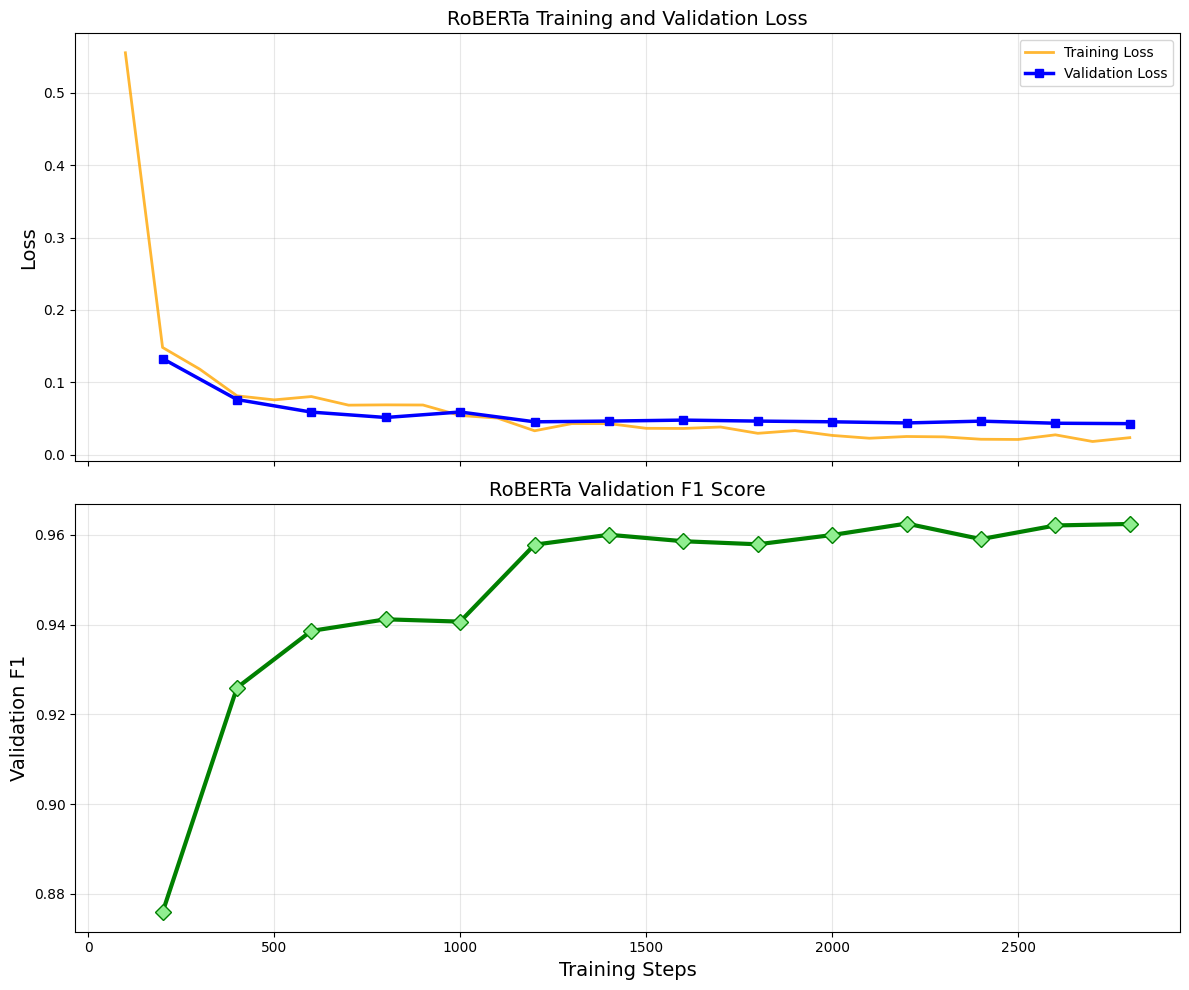

In [12]:
def parse_trainer_history(trainer):
    history = trainer.state.log_history

    train_steps = []
    train_losses = []

    eval_steps = []
    eval_losses = []
    eval_f1s = []

    for log in history:
        if 'loss' in log and 'eval_loss' not in log:
            train_steps.append(log['step'])
            train_losses.append(log['loss'])

        if 'eval_loss' in log or 'eval_f1' in log:
            eval_steps.append(log['step'])
            eval_losses.append(log.get('eval_loss', np.nan))
            eval_f1s.append(log.get('eval_f1', np.nan))

    return {
        'train_steps': np.array(train_steps),
        'train_loss': np.array(train_losses),
        'eval_steps': np.array(eval_steps),
        'eval_loss': np.array(eval_losses),
        'eval_f1': np.array(eval_f1s),
    }

history = parse_trainer_history(trainer)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

ax1.plot(history['train_steps'], history['train_loss'],
         label='Training Loss', color='orange', alpha=0.8, linewidth=2)
ax1.plot(history['eval_steps'], history['eval_loss'],
         's-', label='Validation Loss', color='blue', markersize=6, linewidth=2.5)

ax1.set_ylabel('Loss', fontsize=14)
ax1.set_title('RoBERTa Training and Validation Loss', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history['eval_steps'], history['eval_f1'],
         'D-', color='green', markersize=8, linewidth=3, markerfacecolor='lightgreen')

ax2.set_xlabel('Training Steps', fontsize=14)
ax2.set_ylabel('Validation F1', fontsize=14)
ax2.set_title('RoBERTa Validation F1 Score', fontsize=14)
ax2.grid(True, alpha=0.3)


plt.tight_layout()
plt.savefig(base_path + 'training_curves_final.png', dpi=300, bbox_inches='tight')
plt.show()

In [17]:
test_results = trainer.evaluate(tokenized_datasets["test"])
print(test_results)

{'eval_loss': 0.13028156757354736, 'eval_precision': 0.9146269245953415, 'eval_recall': 0.9297682351760811, 'eval_f1': 0.9221354296233644, 'eval_accuracy': 0.9782485044620967, 'eval_runtime': 12.045, 'eval_samples_per_second': 305.853, 'eval_steps_per_second': 19.178, 'epoch': 3.0}


### Save trained model

In [14]:
model_save_path = base_path + "ner_roberta_model"
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model saved to: {model_save_path}")

Model saved to: /content/drive/MyDrive/conll2003/ner_roberta_model


### Predict on sentences

In [ ]:
model_save_path = base_path + "ner_roberta_model"

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loaded_model = AutoModelForTokenClassification.from_pretrained(model_save_path)
loaded_tokenizer = AutoTokenizer.from_pretrained(model_save_path)

loaded_model.to(device)
print(f"use device: {device}")

def predict_single_sentence(sentence, model, tokenizer, label_list):
    tokens = sentence.split()
    print(f"Input Sentence: {sentence}")
    print(f"Tokenize result: {tokens}")

    inputs = tokenizer(
        tokens,
        is_split_into_words=True,
        return_tensors="pt",
        truncation=True,
        max_length=512,
        padding=True
    )

    inputs = {key: value.to(device) for key, value in inputs.items()}

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=2)

    predicted_labels = predictions[0].cpu().numpy()

    tokenized_input = tokenizer(
        tokens,
        is_split_into_words=True,
        truncation=True,
        max_length=512,
        padding=True
    )
    word_ids = tokenized_input.word_ids()

    previous_word_idx = None
    predicted_ner_tags = []

    for i, word_idx in enumerate(word_ids):
        if word_idx is None:
            continue
        elif word_idx != previous_word_idx:
            predicted_ner_tags.append(label_list[predicted_labels[i]])
            previous_word_idx = word_idx

    return tokens, predicted_ner_tags

def print_ner_results(tokens, labels):
    print("\nNER prediction:")
    print("-" * 40)
    for token, label in zip(tokens, labels):
        print(f"{token:15} -> {label}")
    print("-" * 40)

test_sentences = [
    "John Smith works at Google in California",
    "Apple Inc. is located in Cupertino and Tim Cook is the CEO",
    "Microsoft was founded by Bill Gates and Paul Allen"
]

for i, sentence in enumerate(test_sentences, 1):
    print(f"\nSentence {i}:")
    print("=" * 50)

    tokens, labels = predict_single_sentence(sentence, loaded_model, tokenizer, label_list)
    print_ner_results(tokens, labels)

use device: cuda

Sentence 1:
Input Sentence: John Smith works at Google in California
Tokenize result: ['John', 'Smith', 'works', 'at', 'Google', 'in', 'California']

NER prediction:
----------------------------------------
John            -> B-PER
Smith           -> I-PER
works           -> O
at              -> O
Google          -> B-ORG
in              -> O
California      -> B-LOC
----------------------------------------

Sentence 2:
Input Sentence: Apple Inc. is located in Cupertino and Tim Cook is the CEO
Tokenize result: ['Apple', 'Inc.', 'is', 'located', 'in', 'Cupertino', 'and', 'Tim', 'Cook', 'is', 'the', 'CEO']

NER prediction:
----------------------------------------
Apple           -> B-ORG
Inc.            -> I-ORG
is              -> O
located         -> O
in              -> O
Cupertino       -> B-LOC
and             -> O
Tim             -> B-PER
Cook            -> I-PER
is              -> O
the             -> O
CEO             -> O
----------------------------------------

### Predict and analyze Test set

In [26]:
test_predictions = trainer.predict(tokenized_datasets["test"])

pred_logits = test_predictions.predictions
pred_labels = np.argmax(pred_logits, axis=2)
true_labels = test_predictions.label_ids

test_metrics = compute_metrics((pred_logits, true_labels))
print("=== Test Set Metrics (seqeval) ===")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall   : {test_metrics['recall']:.4f}")
print(f"F1       : {test_metrics['f1']:.4f}")
print(f"Accuracy : {test_metrics['accuracy']:.4f}")

=== Test Set Metrics (seqeval) ===
Precision: 0.9146
Recall   : 0.9298
F1       : 0.9221
Accuracy : 0.9782


In [27]:
print("Collecting mispredicted samples from the test set...")
error_examples = []

original_test_tokens = raw_datasets["test"]["tokens"]
original_test_tags   = raw_datasets["test"]["ner_tags"]   # list of list of int

for idx in tqdm(range(len(pred_labels))):
    pred = pred_labels[idx]
    gold = true_labels[idx]

    tokenized = tokenizer(
        original_test_tokens[idx],
        is_split_into_words=True,
        truncation=True,
        max_length=512,
        return_offsets_mapping=False,
    )
    word_ids = tokenized.word_ids()

    aligned_gold = []
    aligned_pred = []

    prev_wid = None
    pred_idx = 0

    for wid in word_ids:
        if wid is None:
            pred_idx += 1
            continue

        if wid != prev_wid:
            aligned_gold.append(id2label[original_test_tags[idx][wid]])

            if gold[pred_idx] == -100:
                aligned_pred.append("IGNORED")
            else:
                aligned_pred.append(id2label[pred[pred_idx]])

        pred_idx += 1
        prev_wid = wid

    has_error = False
    for g, p in zip(aligned_gold, aligned_pred):
        if g != p and p != "IGNORED":
            has_error = True
            break

    if has_error:
        error_examples.append({
            "idx": idx,
            "sentence": " ".join(original_test_tokens[idx]),
            "tokens": original_test_tokens[idx],
            "gold": aligned_gold,
            "pred": aligned_pred,
        })

print(f"\nNumber of mispredicted samples in test set: {len(error_examples)} / {len(tokenized_datasets['test'])}")
print(f"Test set error rate: {len(error_examples)/len(tokenized_datasets['test']):.4f} ({len(error_examples)/len(tokenized_datasets['test'])*100:.3f}%)\n")

100%|██████████| 3684/3684 [00:08<00:00, 459.41it/s]


Number of mispredicted samples in test set: 498 / 3684
Test set error rate: 0.1352 (13.518%)



In [28]:
random.seed(42)
samples_to_show = random.sample(error_examples, min(5, len(error_examples)))

print("="*80)
print("Random 5 mispredicted examples from the test set:")
print("="*80)

for i, ex in enumerate(samples_to_show, 1):
    print(f"\n【Error Example {i}】")
    print(f"Original: {ex['sentence']}")
    print("Token          Gold        Pred")
    print("-" * 50)
    for t, g, p in zip(ex['tokens'], ex['gold'], ex['pred']):
        marker = "❌" if g != p else "✔"
        print(f"{t:15} {g:11} {p:11} {marker}")
    print()

Random 5 mispredicted examples from the test set:

【Error Example 1】
Original: Witnesses said the protesters were outnumbered by other Italians who waved tricolour flags in the national red , white and green or shouted " Viva Italia " .
Token          Gold        Pred
--------------------------------------------------
Witnesses       O           O           ✔
said            O           O           ✔
the             O           O           ✔
protesters      O           O           ✔
were            O           O           ✔
outnumbered     O           O           ✔
by              O           O           ✔
other           O           O           ✔
Italians        B-MISC      B-MISC      ✔
who             O           O           ✔
waved           O           O           ✔
tricolour       O           O           ✔
flags           O           O           ✔
in              O           O           ✔
the             O           O           ✔
national        O           O           ✔
red     